# Step 1: Environment Setup

In [1]:
# Step 1: Environment Setup
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torchvision import transforms, datasets, models

import importlib

import src.dataset_manager
import src.model_builder
import src.train_utils
import src.occlusion_utils

importlib.reload(src.dataset_manager)
importlib.reload(src.model_builder)
importlib.reload(src.train_utils)
importlib.reload(src.occlusion_utils)

from src.dataset_manager import load_dataset

from src.model_builder import create_model
from src.train_utils import train_and_evaluate_model
from src.occlusion_utils import occlusion_test_evaluation

# 设置设备
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置绘图样式
import matplotlib.pyplot as plt
%matplotlib inline

# 设置随机种子
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# === 通用加载封装 ===
def get_data_loader(config_name):
    """
    快速加载不同实验设置下的数据集。
    参数:
        config_name (str): 选择数据加载配置，如 "plain", "augmented", "imbalanced", "imb_aug"
    返回:
        train_loader, val_loader, class_names
    """
    config_map = {
        "plain": {
            "augment": False,
            "imbalance": False,
            "sample_ratio": 0.5
        },
        "augmented": {
            "augment": True,
            "imbalance": False,
            "sample_ratio": 0.5
        },
        "imbalanced": {
            "augment": False,
            "imbalance": True,
            "sample_ratio": 0.5
        },
        "imb_aug": {
            "augment": True,
            "imbalance": True,
            "sample_ratio": 0.5
        }
    }

    params = config_map[config_name]

    return load_dataset(
        root_folder="../Aerial_Landscapes",
        batch_size=64,
        **params
    )



Device: cuda


# Step 2: Load plain dataset (no augmentation)

/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IM

🚀 Training ResNet18 (Plain Data)

⏳ Training resnet_plain for 5 epochs...
Epoch 1/5 - Loss: 0.4126, Accuracy: 0.8916
Epoch 2/5 - Loss: 0.1010, Accuracy: 0.9732
Epoch 3/5 - Loss: 0.0733, Accuracy: 0.9797
Epoch 4/5 - Loss: 0.0535, Accuracy: 0.9843
Epoch 5/5 - Loss: 0.0416, Accuracy: 0.9892
✅ Finished Training resnet_plain in 2128.19 seconds.

📊 Classification Report:
              precision    recall  f1-score   support

 Agriculture      0.978     0.993     0.985       135
     Airport      0.988     0.977     0.982       171
       Beach      0.976     0.994     0.985       164
        City      0.993     0.973     0.983       150
      Desert      0.974     0.993     0.984       151
      Forest      0.970     0.982     0.976       166
   Grassland      0.988     0.988     0.988       173
     Highway      0.979     0.928     0.953       153
        Lake      0.981     0.975     0.978       157
    Mountain      0.989     0.966     0.977       179
     Parking      1.000     0.987    

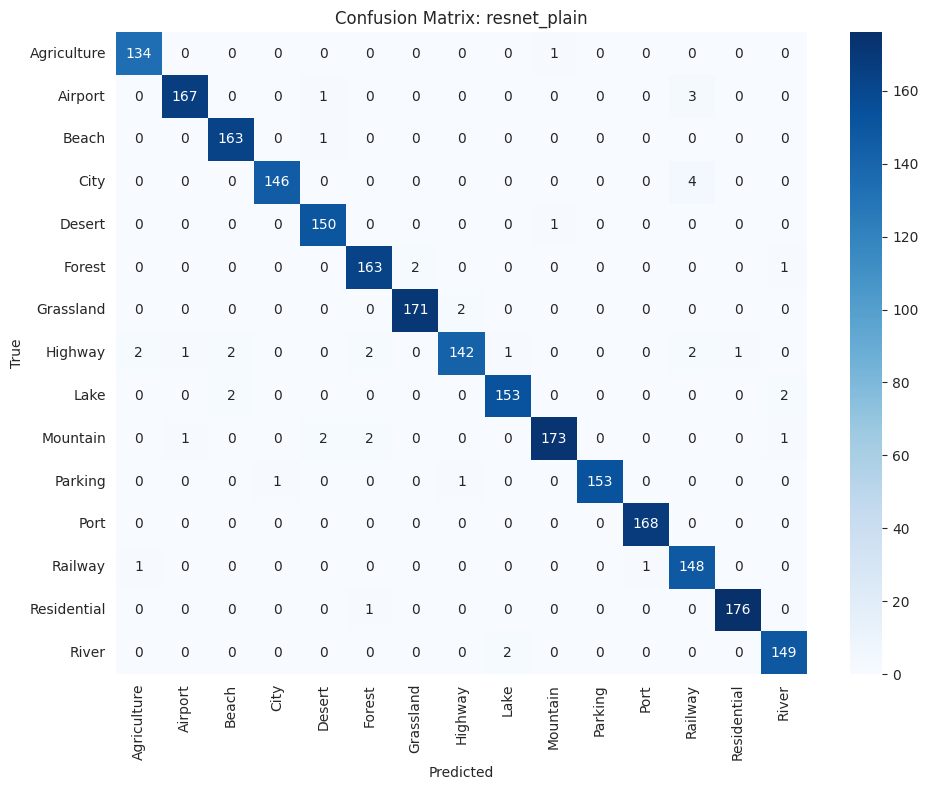

In [2]:
# Step 2: Load plain dataset (no augmentation)
from src.dataset_manager import load_dataset
from src.model_builder import create_model
from src.train_utils import train_and_evaluate_model
import torch

# 设备设定
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 加载无增强数据，显式指定数据集路径
train_loader_plain, val_loader_plain, class_names = get_data_loader("plain")

# 初始化模型
resnet_plain = create_model("resnet18", num_classes=len(class_names)).to(DEVICE)
mobilenet_plain = create_model("mobilenet_v2", num_classes=len(class_names)).to(DEVICE)

# 训练 ResNet18 (Plain Data)
print("🚀 Training ResNet18 (Plain Data)")
resnet_plain_metrics = train_and_evaluate_model(
    resnet_plain, train_loader_plain, val_loader_plain,
    DEVICE, class_names, label="resnet_plain"
)




🚀 Training MobileNetV2 (Plain Data)

⏳ Training mobilenet_plain for 5 epochs...
Epoch 1/5 - Loss: 0.5958, Accuracy: 0.8525
Epoch 2/5 - Loss: 0.1300, Accuracy: 0.9652
Epoch 3/5 - Loss: 0.0850, Accuracy: 0.9782
Epoch 4/5 - Loss: 0.0523, Accuracy: 0.9849
Epoch 5/5 - Loss: 0.0456, Accuracy: 0.9885
✅ Finished Training mobilenet_plain in 2042.97 seconds.

📊 Classification Report:
              precision    recall  f1-score   support

 Agriculture      0.978     0.985     0.982       135
     Airport      0.982     0.965     0.973       171
       Beach      0.965     1.000     0.982       164
        City      0.986     0.967     0.976       150
      Desert      0.987     0.974     0.980       151
      Forest      0.959     0.982     0.970       166
   Grassland      0.988     0.948     0.968       173
     Highway      0.968     0.974     0.971       153
        Lake      0.968     0.968     0.968       157
    Mountain      0.961     0.961     0.961       179
     Parking      0.994    

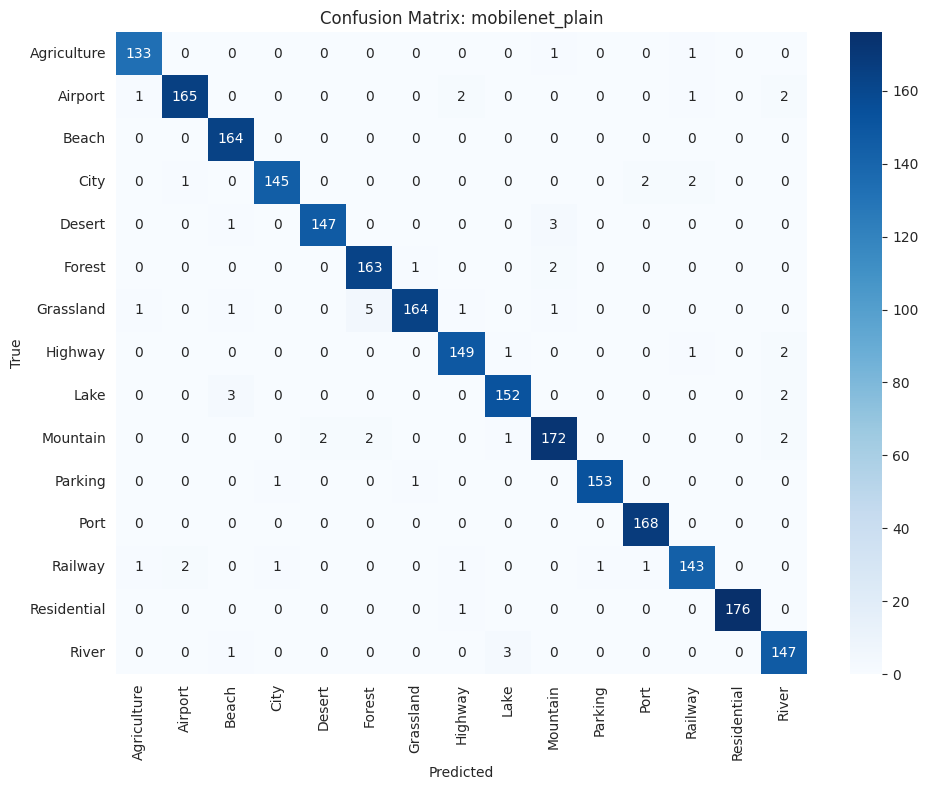

In [3]:
# 训练 MobileNetV2 (Plain Data)
print("\n🚀 Training MobileNetV2 (Plain Data)")
mobilenet_plain_metrics = train_and_evaluate_model(
    mobilenet_plain, train_loader_plain, val_loader_plain,
    DEVICE, class_names, label="mobilenet_plain"
)

# Step 3: Load Augmented Dataset & Train (Full Data with Augmentation)

/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IM


🚀 Training ResNet18 (Augmented Data)

⏳ Training resnet_aug for 5 epochs...
Epoch 1/5 - Loss: 0.4232, Accuracy: 0.8919
Epoch 2/5 - Loss: 0.0981, Accuracy: 0.9743
Epoch 3/5 - Loss: 0.0788, Accuracy: 0.9790
Epoch 4/5 - Loss: 0.0424, Accuracy: 0.9884
Epoch 5/5 - Loss: 0.0377, Accuracy: 0.9883
✅ Finished Training resnet_aug in 1788.94 seconds.

📊 Classification Report:
              precision    recall  f1-score   support

 Agriculture      0.993     0.985     0.989       135
     Airport      0.982     0.982     0.982       171
       Beach      0.982     0.994     0.988       164
        City      0.980     0.993     0.987       150
      Desert      0.949     0.987     0.968       151
      Forest      0.953     0.976     0.964       166
   Grassland      0.988     0.960     0.974       173
     Highway      0.973     0.954     0.964       153
        Lake      0.994     0.981     0.987       157
    Mountain      0.982     0.933     0.957       179
     Parking      1.000     0.994   

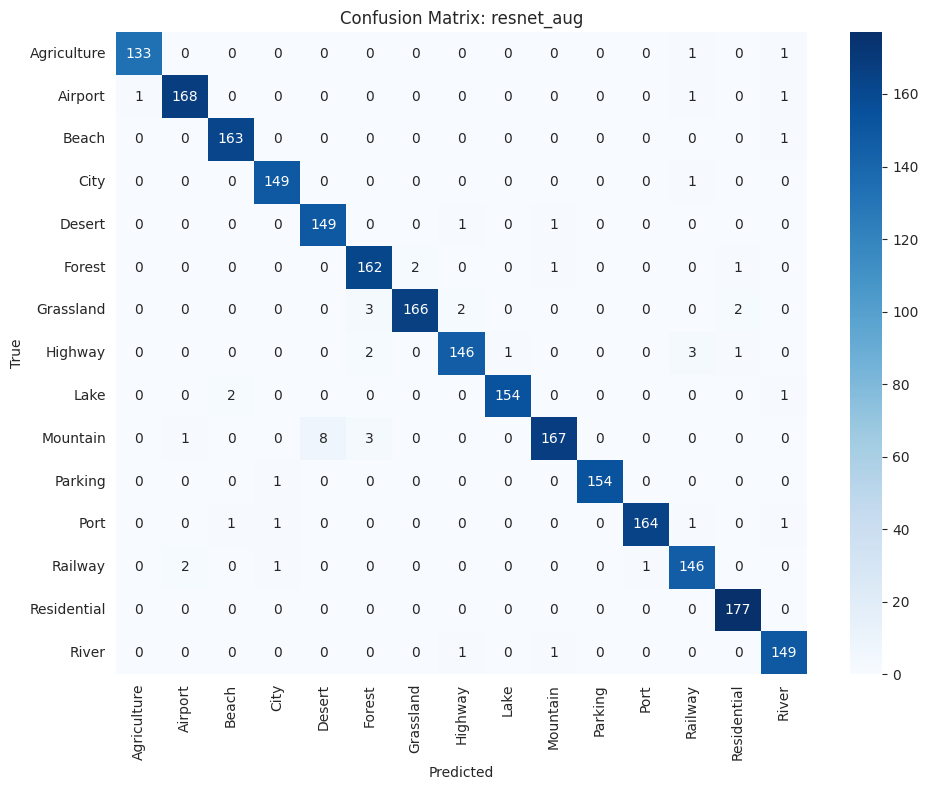

In [4]:
# Step 3: Load dataset with augmentation
train_loader_aug, val_loader_aug, _ = get_data_loader("augmented")

# 初始化模型
resnet_aug = create_model("resnet18", num_classes=len(class_names)).to(DEVICE)
mobilenet_aug = create_model("mobilenet_v2", num_classes=len(class_names)).to(DEVICE)

# 训练 ResNet18 (Augmented Data)
print("\n🚀 Training ResNet18 (Augmented Data)")
resnet_aug_metrics = train_and_evaluate_model(resnet_aug, train_loader_aug, val_loader_aug, DEVICE, class_names, label="resnet_aug")



🚀 Training MobileNetV2 (Augmented Data)

⏳ Training mobilenet_aug for 5 epochs...
Epoch 1/5 - Loss: 0.5596, Accuracy: 0.8585
Epoch 2/5 - Loss: 0.1353, Accuracy: 0.9631
Epoch 3/5 - Loss: 0.0769, Accuracy: 0.9796
Epoch 4/5 - Loss: 0.0606, Accuracy: 0.9833
Epoch 5/5 - Loss: 0.0464, Accuracy: 0.9869
✅ Finished Training mobilenet_aug in 1210.77 seconds.

📊 Classification Report:
              precision    recall  f1-score   support

 Agriculture      0.985     0.985     0.985       135
     Airport      0.994     0.994     0.994       171
       Beach      0.965     1.000     0.982       164
        City      0.974     1.000     0.987       150
      Desert      0.980     0.974     0.977       151
      Forest      0.976     0.976     0.976       166
   Grassland      0.977     0.965     0.971       173
     Highway      0.967     0.948     0.957       153
        Lake      0.975     0.975     0.975       157
    Mountain      0.978     0.978     0.978       179
     Parking      0.993    

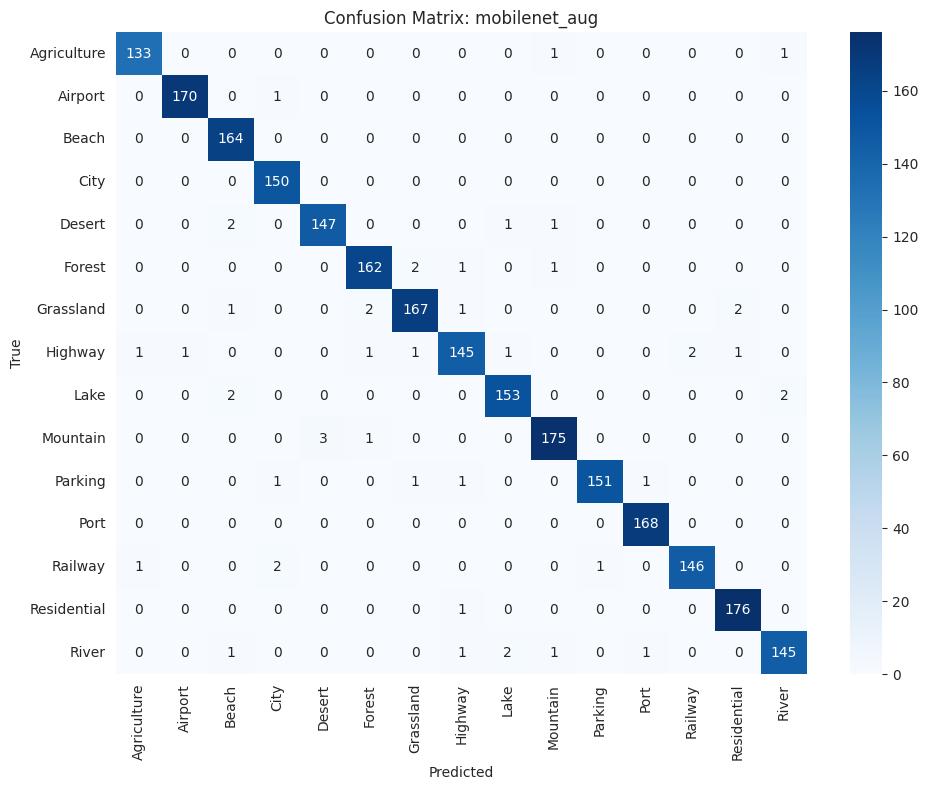

In [5]:
# 训练 MobileNetV2 (Augmented Data)
print("\n🚀 Training MobileNetV2 (Augmented Data)")
mobilenet_aug_metrics = train_and_evaluate_model(mobilenet_aug, train_loader_aug, val_loader_aug, DEVICE, class_names, label="mobilenet_aug")

# Step 4: Compare Plain vs Augmented Results

In [6]:
# STEP 4: Compare Plain vs Augmented Results
import pandas as pd

# 收集每个模型的评估结果（这些结果来自 Step 2 和 Step 3）
df_dl_compare = pd.DataFrame([
    {
        "Model": "ResNet18", "Setting": "Plain",
        "Accuracy": resnet_plain_metrics["accuracy"],
        "F1": resnet_plain_metrics["f1"],
        "Precision": resnet_plain_metrics["precision"],
        "Recall": resnet_plain_metrics["recall"],
        "TrainTime(s)": resnet_plain_metrics["train_time"]
    },
    {
        "Model": "ResNet18", "Setting": "Augmented",
        "Accuracy": resnet_aug_metrics["accuracy"],
        "F1": resnet_aug_metrics["f1"],
        "Precision": resnet_aug_metrics["precision"],
        "Recall": resnet_aug_metrics["recall"],
        "TrainTime(s)": resnet_aug_metrics["train_time"]
    },
    {
        "Model": "MobileNetV2", "Setting": "Plain",
        "Accuracy": mobilenet_plain_metrics["accuracy"],
        "F1": mobilenet_plain_metrics["f1"],
        "Precision": mobilenet_plain_metrics["precision"],
        "Recall": mobilenet_plain_metrics["recall"],
        "TrainTime(s)": mobilenet_plain_metrics["train_time"]
    },
    {
        "Model": "MobileNetV2", "Setting": "Augmented",
        "Accuracy": mobilenet_aug_metrics["accuracy"],
        "F1": mobilenet_aug_metrics["f1"],
        "Precision": mobilenet_aug_metrics["precision"],
        "Recall": mobilenet_aug_metrics["recall"],
        "TrainTime(s)": mobilenet_aug_metrics["train_time"]
    }
])

# 显示汇总表格
print("📊 Summary: Plain vs Augmented Data Performance Comparison")
display(df_dl_compare.style.set_caption("Deep Learning Classification Performance").format(precision=4))


📊 Summary: Plain vs Augmented Data Performance Comparison


,Model,Setting,Accuracy,F1,Precision,Recall,TrainTime(s)
0,ResNet18,Plain,0.9817,0.9816,0.9818,0.9817,2128.1900
1,ResNet18,Augmented,0.9779,0.9779,0.9781,0.9779,1788.9400
2,MobileNetV2,Plain,0.9754,0.9754,0.9756,0.9754,2042.9700
3,MobileNetV2,Augmented,0.9800,0.9800,0.9800,0.9800,1210.7700


# Step 5: Load imbalanced dataset and apply targeted augmentation


/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IM

🚫 Training ResNet18 on Imbalanced Data (No Aug)

⏳ Training resnet_imb for 5 epochs...
Epoch 1/5 - Loss: 0.6847, Accuracy: 0.8281
Epoch 2/5 - Loss: 0.1240, Accuracy: 0.9718
Epoch 3/5 - Loss: 0.0794, Accuracy: 0.9804
Epoch 4/5 - Loss: 0.0531, Accuracy: 0.9867
Epoch 5/5 - Loss: 0.0424, Accuracy: 0.9929
✅ Finished Training resnet_imb in 512.33 seconds.

📊 Classification Report:
              precision    recall  f1-score   support

 Agriculture      0.988     0.988     0.988        83
     Airport      0.889     0.960     0.923        75
       Beach      0.989     0.968     0.979        95
        City      0.976     0.943     0.959        87
      Desert      0.961     0.961     0.961        77
      Forest      0.932     0.971     0.951        70
   Grassland      1.000     0.934     0.966        76
     Highway      0.965     0.976     0.970        84
        Lake      0.944     0.977     0.960        86
    Mountain      0.936     0.961     0.948        76
     Parking      0.986    

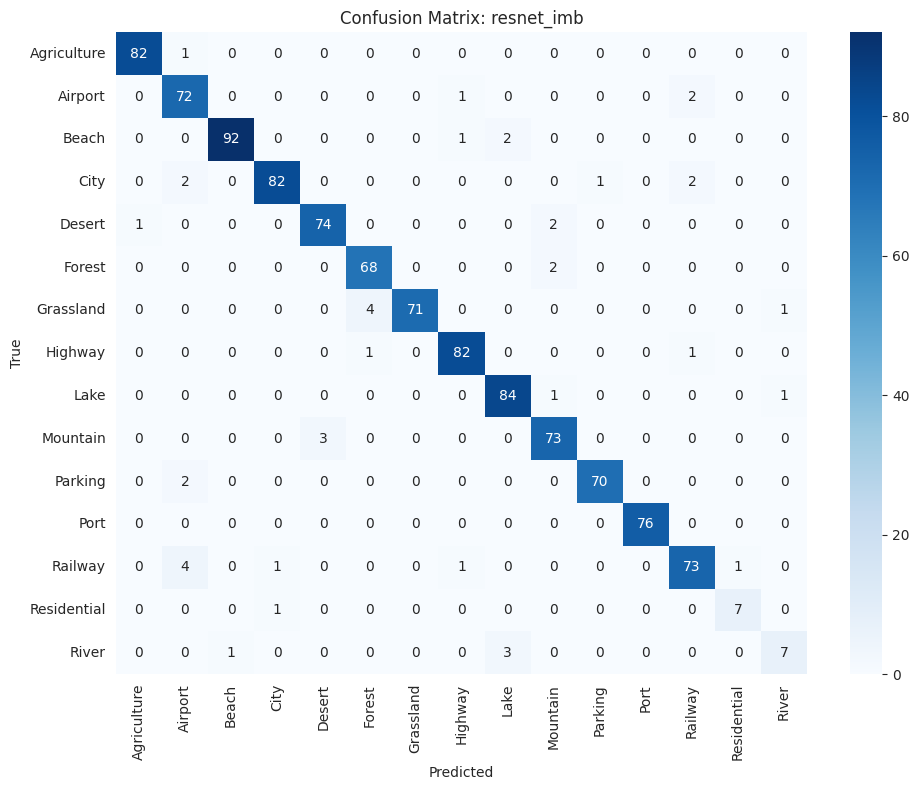

🚫 Training MobileNetV2 on Imbalanced Data (No Aug)

⏳ Training mobilenet_imb for 5 epochs...
Epoch 1/5 - Loss: 0.9386, Accuracy: 0.7822
Epoch 2/5 - Loss: 0.1851, Accuracy: 0.9553
Epoch 3/5 - Loss: 0.0952, Accuracy: 0.9761
Epoch 4/5 - Loss: 0.0765, Accuracy: 0.9820
Epoch 5/5 - Loss: 0.0495, Accuracy: 0.9867
✅ Finished Training mobilenet_imb in 505.32 seconds.

📊 Classification Report:
              precision    recall  f1-score   support

 Agriculture      0.987     0.940     0.963        83
     Airport      0.924     0.973     0.948        75
       Beach      0.979     0.979     0.979        95
        City      0.955     0.977     0.966        87
      Desert      0.973     0.948     0.961        77
      Forest      0.904     0.943     0.923        70
   Grassland      0.947     0.934     0.940        76
     Highway      1.000     0.964     0.982        84
        Lake      0.965     0.965     0.965        86
    Mountain      0.926     0.987     0.955        76
     Parking      

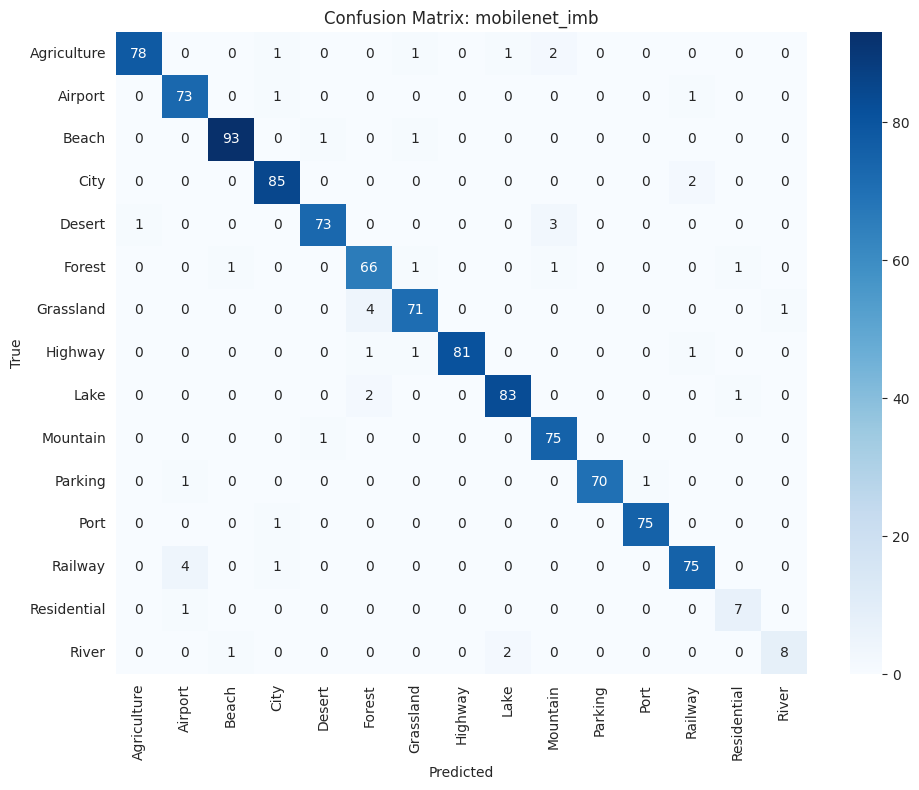

/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IM

✅ Training ResNet18 on Imbalanced + Augmented Data

⏳ Training resnet_imb_aug for 5 epochs...
Epoch 1/5 - Loss: 0.6822, Accuracy: 0.8331
Epoch 2/5 - Loss: 0.1467, Accuracy: 0.9614
Epoch 3/5 - Loss: 0.0893, Accuracy: 0.9799
Epoch 4/5 - Loss: 0.0482, Accuracy: 0.9891
Epoch 5/5 - Loss: 0.0387, Accuracy: 0.9896
✅ Finished Training resnet_imb_aug in 508.44 seconds.

📊 Classification Report:
              precision    recall  f1-score   support

 Agriculture      0.976     0.976     0.976        83
     Airport      0.908     0.920     0.914        75
       Beach      0.979     0.989     0.984        95
        City      0.905     0.989     0.945        87
      Desert      0.987     0.961     0.974        77
      Forest      0.932     0.971     0.951        70
   Grassland      1.000     0.947     0.973        76
     Highway      0.953     0.964     0.959        84
        Lake      0.963     0.895     0.928        86
    Mountain      0.914     0.974     0.943        76
     Parking    

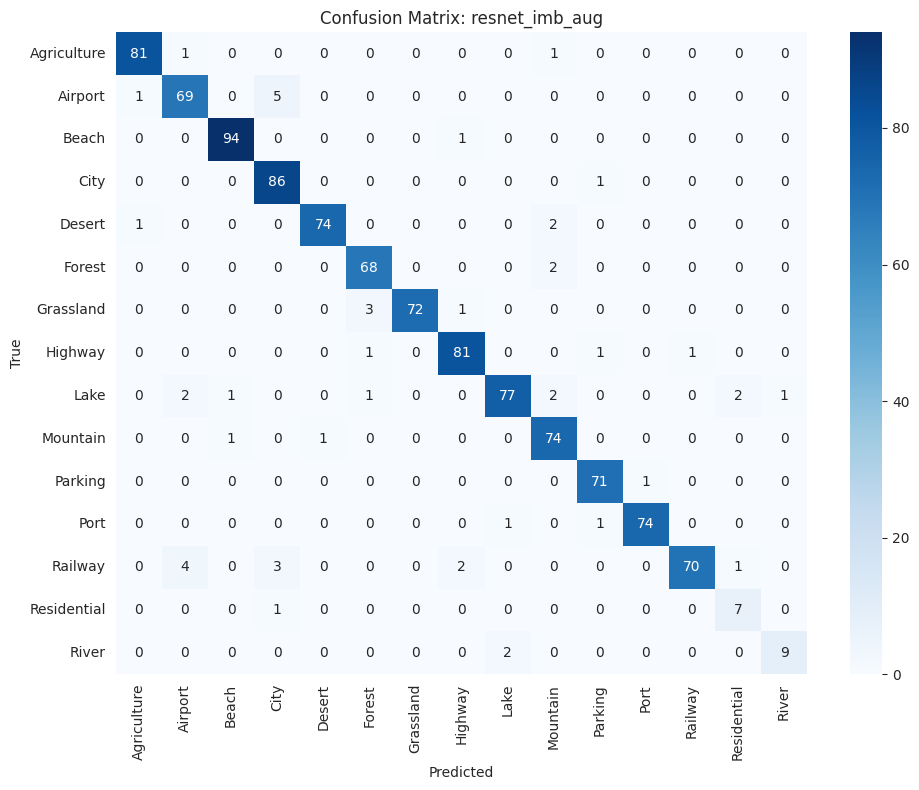

✅ Training MobileNetV2 on Imbalanced + Augmented Data

⏳ Training mobilenet_imb_aug for 5 epochs...
Epoch 1/5 - Loss: 0.9750, Accuracy: 0.7678
Epoch 2/5 - Loss: 0.1831, Accuracy: 0.9550
Epoch 3/5 - Loss: 0.1023, Accuracy: 0.9766
Epoch 4/5 - Loss: 0.0714, Accuracy: 0.9818
Epoch 5/5 - Loss: 0.0563, Accuracy: 0.9846
✅ Finished Training mobilenet_imb_aug in 506.82 seconds.

📊 Classification Report:
              precision    recall  f1-score   support

 Agriculture      1.000     0.988     0.994        83
     Airport      0.904     1.000     0.949        75
       Beach      0.989     0.979     0.984        95
        City      0.966     0.989     0.977        87
      Desert      0.973     0.935     0.954        77
      Forest      0.944     0.971     0.958        70
   Grassland      1.000     0.974     0.987        76
     Highway      0.988     0.976     0.982        84
        Lake      0.976     0.965     0.971        86
    Mountain      0.914     0.974     0.943        76
     Pa

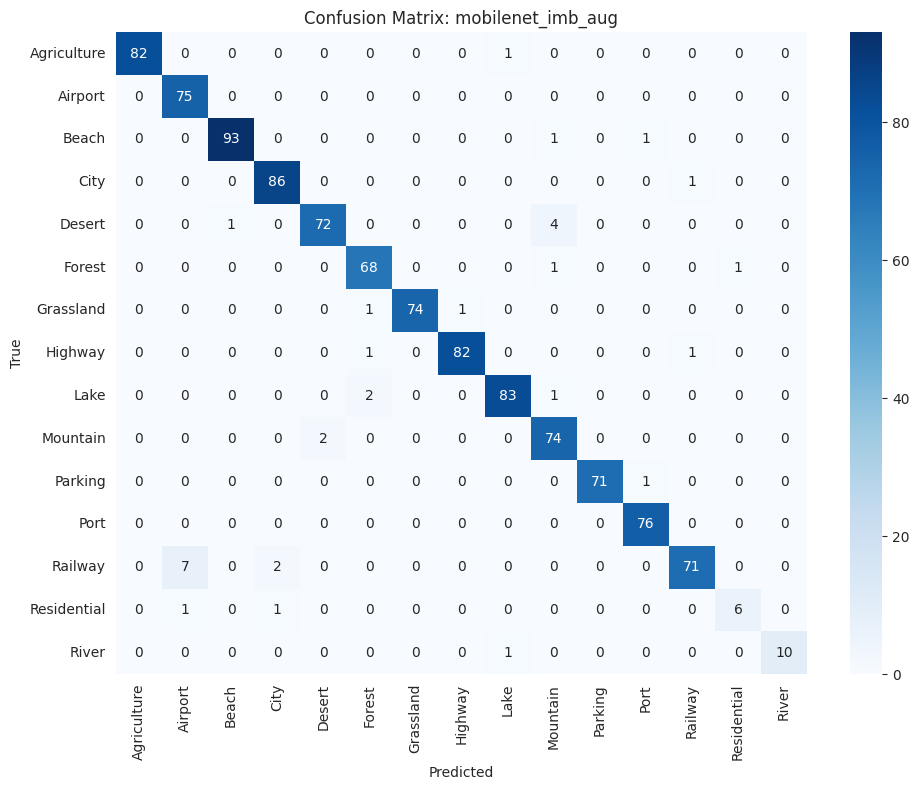

📊 Step 5 Results: Imbalanced vs Imbalanced+Augmented


,Model,Setting,Accuracy,F1,Precision,Recall,TrainTime(s)
0,ResNet18,Imbalanced,0.9593,0.9592,0.9598,0.9593,512.3300
1,ResNet18,Imbalanced + Aug,0.9536,0.9536,0.9553,0.9536,508.4400
2,MobileNetV2,Imbalanced,0.9593,0.9593,0.9601,0.9593,505.3200
3,MobileNetV2,Imbalanced + Aug,0.9688,0.9687,0.9697,0.9688,506.8200


In [7]:
# STEP 5: Handling Class Imbalance with Targeted Augmentation
import torch
import pandas as pd
from src.dataset_manager import load_dataset
from src.model_builder import create_model
from src.train_utils import train_and_evaluate_model

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =====================
# 1. 加载不平衡数据（无增强）
# =====================
# Step 5: Imbalanced Data (无增强)
train_loader_imb, val_loader_imb, class_names = get_data_loader("imbalanced")

# 初始化模型（无增强）
resnet_imb = create_model("resnet18", num_classes=len(class_names)).to(DEVICE)
mobilenet_imb = create_model("mobilenet_v2", num_classes=len(class_names)).to(DEVICE)

# 训练 ResNet18
print("🚫 Training ResNet18 on Imbalanced Data (No Aug)")
resnet_imb_metrics = train_and_evaluate_model(
    resnet_imb, train_loader_imb, val_loader_imb, DEVICE, class_names, label="resnet_imb"
)

# 训练 MobileNetV2
print("🚫 Training MobileNetV2 on Imbalanced Data (No Aug)")
mobilenet_imb_metrics = train_and_evaluate_model(
    mobilenet_imb, train_loader_imb, val_loader_imb, DEVICE, class_names, label="mobilenet_imb"
)

# =====================
# 2. 加载不平衡数据（对少数类进行增强）
# =====================
# Step 5: Imbalanced + Augmentation
train_loader_imb_aug, val_loader_imb_aug, _ = get_data_loader("imb_aug")

# 初始化模型（增强）
resnet_imb_aug = create_model("resnet18", num_classes=len(class_names)).to(DEVICE)
mobilenet_imb_aug = create_model("mobilenet_v2", num_classes=len(class_names)).to(DEVICE)

# 训练 ResNet18
print("✅ Training ResNet18 on Imbalanced + Augmented Data")
resnet_imb_aug_metrics = train_and_evaluate_model(
    resnet_imb_aug, train_loader_imb_aug, val_loader_imb_aug, DEVICE, class_names, label="resnet_imb_aug"
)

# 训练 MobileNetV2
print("✅ Training MobileNetV2 on Imbalanced + Augmented Data")
mobilenet_imb_aug_metrics = train_and_evaluate_model(
    mobilenet_imb_aug, train_loader_imb_aug, val_loader_imb_aug, DEVICE, class_names, label="mobilenet_imb_aug"
)

# =====================
# 3. 对比增强前后的评分指标
# =====================
df_step5_compare = pd.DataFrame([
    {
        "Model": "ResNet18", "Setting": "Imbalanced",
        "Accuracy": resnet_imb_metrics["accuracy"],
        "F1": resnet_imb_metrics["f1"],
        "Precision": resnet_imb_metrics["precision"],
        "Recall": resnet_imb_metrics["recall"],
        "TrainTime(s)": resnet_imb_metrics["train_time"]
    },
    {
        "Model": "ResNet18", "Setting": "Imbalanced + Aug",
        "Accuracy": resnet_imb_aug_metrics["accuracy"],
        "F1": resnet_imb_aug_metrics["f1"],
        "Precision": resnet_imb_aug_metrics["precision"],
        "Recall": resnet_imb_aug_metrics["recall"],
        "TrainTime(s)": resnet_imb_aug_metrics["train_time"]
    },
    {
        "Model": "MobileNetV2", "Setting": "Imbalanced",
        "Accuracy": mobilenet_imb_metrics["accuracy"],
        "F1": mobilenet_imb_metrics["f1"],
        "Precision": mobilenet_imb_metrics["precision"],
        "Recall": mobilenet_imb_metrics["recall"],
        "TrainTime(s)": mobilenet_imb_metrics["train_time"]
    },
    {
        "Model": "MobileNetV2", "Setting": "Imbalanced + Aug",
        "Accuracy": mobilenet_imb_aug_metrics["accuracy"],
        "F1": mobilenet_imb_aug_metrics["f1"],
        "Precision": mobilenet_imb_aug_metrics["precision"],
        "Recall": mobilenet_imb_aug_metrics["recall"],
        "TrainTime(s)": mobilenet_imb_aug_metrics["train_time"]
    }
])

# 显示结果对比表格
from IPython.display import display
print("📊 Step 5 Results: Imbalanced vs Imbalanced+Augmented")
display(df_step5_compare.style.set_caption("Class Imbalance + Targeted Augmentation").format(precision=4))


In [9]:
from sklearn.metrics import classification_report
import pandas as pd

# 保存四个模型 + 四个验证集，供下个 notebook cell 使用
saved_models = {
    "resnet_imb": resnet_imb,
    "resnet_imb_aug": resnet_imb_aug,
    "mobilenet_imb": mobilenet_imb,
    "mobilenet_imb_aug": mobilenet_imb_aug,
}
saved_val_loaders = {
    "imb": val_loader_imb,
    "aug": val_loader_imb_aug,
}
saved_class_names = class_names

# ========== 工具函数：计算各类别的分类表现 ==========
def get_classwise_metrics(model, val_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    return report

# ========== 评估四个模型 ==========
report_imb_resnet   = get_classwise_metrics(saved_models["resnet_imb"], saved_val_loaders["imb"], saved_class_names)
report_aug_resnet   = get_classwise_metrics(saved_models["resnet_imb_aug"], saved_val_loaders["aug"], saved_class_names)
report_imb_mobile   = get_classwise_metrics(saved_models["mobilenet_imb"], saved_val_loaders["imb"], saved_class_names)
report_aug_mobile   = get_classwise_metrics(saved_models["mobilenet_imb_aug"], saved_val_loaders["aug"], saved_class_names)

# ========== 只分析增强的类（假设为最后两个类） ==========
target_classes = saved_class_names[-2:]

df_aug_targets = pd.DataFrame([
    {
        "Model": "ResNet18", "Class": cls,
        "Setting": "Imbalanced", "F1": report_imb_resnet[cls]["f1-score"], "Precision": report_imb_resnet[cls]["precision"], "Recall": report_imb_resnet[cls]["recall"]
    }
    for cls in target_classes
] + [
    {
        "Model": "ResNet18", "Class": cls,
        "Setting": "Imbalanced + Aug", "F1": report_aug_resnet[cls]["f1-score"], "Precision": report_aug_resnet[cls]["precision"], "Recall": report_aug_resnet[cls]["recall"]
    }
    for cls in target_classes
] + [
    {
        "Model": "MobileNetV2", "Class": cls,
        "Setting": "Imbalanced", "F1": report_imb_mobile[cls]["f1-score"], "Precision": report_imb_mobile[cls]["precision"], "Recall": report_imb_mobile[cls]["recall"]
    }
    for cls in target_classes
] + [
    {
        "Model": "MobileNetV2", "Class": cls,
        "Setting": "Imbalanced + Aug", "F1": report_aug_mobile[cls]["f1-score"], "Precision": report_aug_mobile[cls]["precision"], "Recall": report_aug_mobile[cls]["recall"]
    }
    for cls in target_classes
])

# ========== 打印分析结果 ==========
from IPython.display import display
print("🔍 Comparison on Augmented Target Classes")
display(df_aug_targets.style.set_caption("Performance on Augmented Classes Only").format(precision=4))


🔍 Comparison on Augmented Target Classes


,Model,Class,Setting,F1,Precision,Recall
0,ResNet18,Residential,Imbalanced,0.8750,0.8750,0.8750
1,ResNet18,River,Imbalanced,0.7000,0.7778,0.6364
2,ResNet18,Residential,Imbalanced + Aug,0.7778,0.7000,0.8750
3,ResNet18,River,Imbalanced + Aug,0.8571,0.9000,0.8182
4,MobileNetV2,Residential,Imbalanced,0.8235,0.7778,0.8750
5,MobileNetV2,River,Imbalanced,0.8000,0.8889,0.7273
6,MobileNetV2,Residential,Imbalanced + Aug,0.8000,0.8571,0.7500
7,MobileNetV2,River,Imbalanced + Aug,0.9524,1.0000,0.9091


# Step 6: Occlusion / Noise Robustness Test

🔍 Starting Occlusion Evaluation...

===[OcclusionTest_ResNet_Plain]===  resnet_plain occlude_size=60
遮挡后: Acc=0.927, F1=0.930, Precision=0.953, Recall=0.927


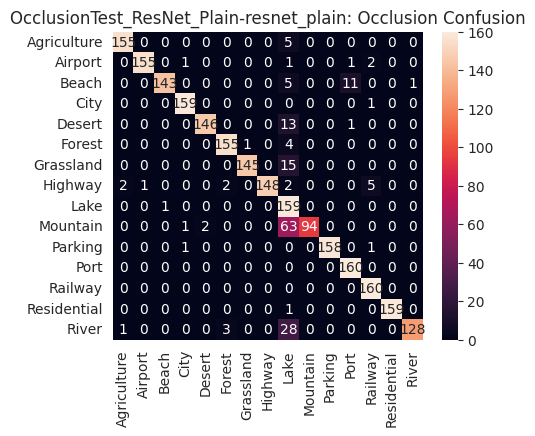

Classification Report (遮挡后):
              precision    recall  f1-score   support

 Agriculture       0.98      0.97      0.97       160
     Airport       0.99      0.97      0.98       160
       Beach       0.99      0.89      0.94       160
        City       0.98      0.99      0.99       160
      Desert       0.99      0.91      0.95       160
      Forest       0.97      0.97      0.97       160
   Grassland       0.99      0.91      0.95       160
     Highway       1.00      0.93      0.96       160
        Lake       0.54      0.99      0.70       160
    Mountain       1.00      0.59      0.74       160
     Parking       1.00      0.99      0.99       160
        Port       0.92      1.00      0.96       160
     Railway       0.95      1.00      0.97       160
 Residential       1.00      0.99      1.00       160
       River       0.99      0.80      0.89       160

    accuracy                           0.93      2400
   macro avg       0.95      0.93      0.93      24

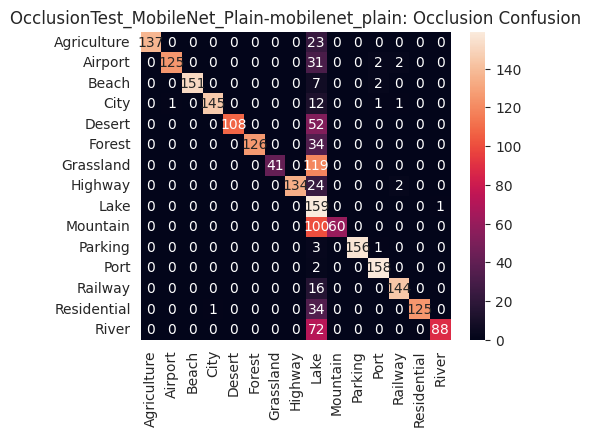

Classification Report (遮挡后):
              precision    recall  f1-score   support

 Agriculture       1.00      0.86      0.92       160
     Airport       0.99      0.78      0.87       160
       Beach       1.00      0.94      0.97       160
        City       0.99      0.91      0.95       160
      Desert       1.00      0.68      0.81       160
      Forest       1.00      0.79      0.88       160
   Grassland       1.00      0.26      0.41       160
     Highway       1.00      0.84      0.91       160
        Lake       0.23      0.99      0.38       160
    Mountain       1.00      0.38      0.55       160
     Parking       1.00      0.97      0.99       160
        Port       0.96      0.99      0.98       160
     Railway       0.97      0.90      0.93       160
 Residential       1.00      0.78      0.88       160
       River       0.99      0.55      0.71       160

    accuracy                           0.77      2400
   macro avg       0.94      0.77      0.81      24

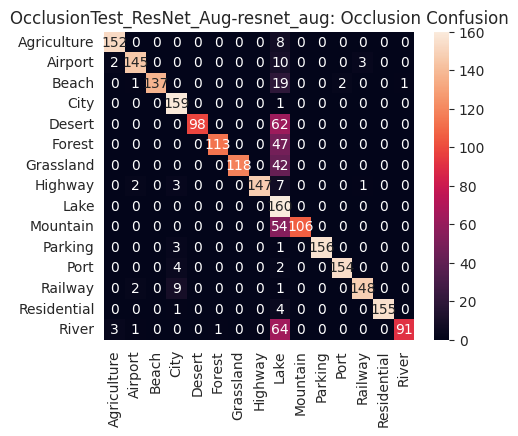

Classification Report (遮挡后):
              precision    recall  f1-score   support

 Agriculture       0.97      0.95      0.96       160
     Airport       0.96      0.91      0.93       160
       Beach       1.00      0.86      0.92       160
        City       0.89      0.99      0.94       160
      Desert       1.00      0.61      0.76       160
      Forest       0.99      0.71      0.82       160
   Grassland       1.00      0.74      0.85       160
     Highway       1.00      0.92      0.96       160
        Lake       0.33      1.00      0.50       160
    Mountain       1.00      0.66      0.80       160
     Parking       1.00      0.97      0.99       160
        Port       0.99      0.96      0.97       160
     Railway       0.97      0.93      0.95       160
 Residential       1.00      0.97      0.98       160
       River       0.99      0.57      0.72       160

    accuracy                           0.85      2400
   macro avg       0.94      0.85      0.87      24

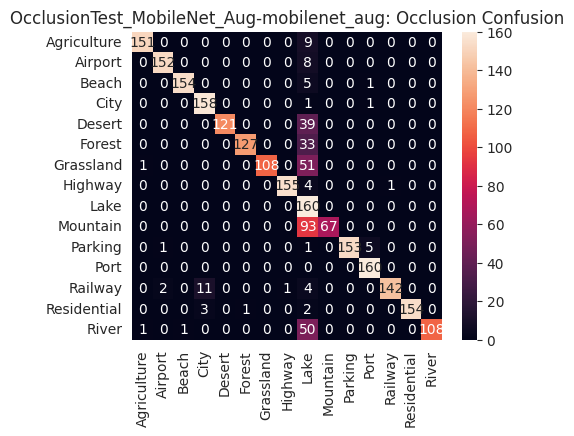

Classification Report (遮挡后):
              precision    recall  f1-score   support

 Agriculture       0.99      0.94      0.96       160
     Airport       0.98      0.95      0.97       160
       Beach       0.99      0.96      0.98       160
        City       0.92      0.99      0.95       160
      Desert       1.00      0.76      0.86       160
      Forest       0.99      0.79      0.88       160
   Grassland       1.00      0.68      0.81       160
     Highway       0.99      0.97      0.98       160
        Lake       0.35      1.00      0.52       160
    Mountain       1.00      0.42      0.59       160
     Parking       1.00      0.96      0.98       160
        Port       0.96      1.00      0.98       160
     Railway       0.99      0.89      0.94       160
 Residential       1.00      0.96      0.98       160
       River       1.00      0.68      0.81       160

    accuracy                           0.86      2400
   macro avg       0.94      0.86      0.88      24

In [8]:
from src.occlusion_utils import occlusion_test_evaluation
import torchvision.transforms as T
# 加载测试路径和标签
from src.dataset_manager import load_data_path_only
test_paths, test_labels = load_data_path_only(imbalance=False)[2:4]  # 获取 test_paths, test_labels

# 初始化结果列表
all_results = []

# 保持与训练一致的预处理
test_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Step 6: Occlusion Evaluation (Plain + Augmented)
print("🔍 Starting Occlusion Evaluation...")

# Plain Data 上的模型遮挡测试
occlusion_test_evaluation(
    model=resnet_plain,
    test_paths=test_paths,
    test_labels=test_labels,
    transform=test_transform,
    device=DEVICE,
    occlude_size=60,
    scenario="OcclusionTest_ResNet_Plain",
    model_name="resnet_plain",
    class_names=class_names,
    results_list=all_results
)

occlusion_test_evaluation(
    model=mobilenet_plain,
    test_paths=test_paths,
    test_labels=test_labels,
    transform=test_transform,
    device=DEVICE,
    occlude_size=60,
    scenario="OcclusionTest_MobileNet_Plain",
    model_name="mobilenet_plain",
    class_names=class_names,
    results_list=all_results
)

# Augmented Data 上的模型遮挡测试
occlusion_test_evaluation(
    model=resnet_aug,
    test_paths=test_paths,
    test_labels=test_labels,
    transform=test_transform,
    device=DEVICE,
    occlude_size=60,
    scenario="OcclusionTest_ResNet_Aug",
    model_name="resnet_aug",
    class_names=class_names,
    results_list=all_results
)

occlusion_test_evaluation(
    model=mobilenet_aug,
    test_paths=test_paths,
    test_labels=test_labels,
    transform=test_transform,
    device=DEVICE,
    occlude_size=60,
    scenario="OcclusionTest_MobileNet_Aug",
    model_name="mobilenet_aug",
    class_names=class_names,
    results_list=all_results
)

print("✅ Step 6 Completed.")


# Step 7：Performance Summary & Comparison

In [10]:
# Step 7: Summary of Results from All Steps
import pandas as pd
from IPython.display import display

# 表格 1：Plain vs Augmented (Balanced)
df_balanced = pd.DataFrame([
    {
        "Model": "ResNet18", "Setting": "Balanced", "Accuracy": resnet_plain_metrics["accuracy"],
        "F1": resnet_plain_metrics["f1"], "Precision": resnet_plain_metrics["precision"],
        "Recall": resnet_plain_metrics["recall"], "TrainTime(s)": resnet_plain_metrics["train_time"]
    },
    {
        "Model": "ResNet18", "Setting": "Balanced + Aug", "Accuracy": resnet_aug_metrics["accuracy"],
        "F1": resnet_aug_metrics["f1"], "Precision": resnet_aug_metrics["precision"],
        "Recall": resnet_aug_metrics["recall"], "TrainTime(s)": resnet_aug_metrics["train_time"]
    },
    {
        "Model": "MobileNetV2", "Setting": "Balanced", "Accuracy": mobilenet_plain_metrics["accuracy"],
        "F1": mobilenet_plain_metrics["f1"], "Precision": mobilenet_plain_metrics["precision"],
        "Recall": mobilenet_plain_metrics["recall"], "TrainTime(s)": mobilenet_plain_metrics["train_time"]
    },
    {
        "Model": "MobileNetV2", "Setting": "Balanced + Aug", "Accuracy": mobilenet_aug_metrics["accuracy"],
        "F1": mobilenet_aug_metrics["f1"], "Precision": mobilenet_aug_metrics["precision"],
        "Recall": mobilenet_aug_metrics["recall"], "TrainTime(s)": mobilenet_aug_metrics["train_time"]
    },
])
print("📊 Performance on Balanced Dataset (Plain vs Augmented):")
display(df_balanced.style.set_caption("Balanced Dataset: Plain vs Augmented").format(precision=4))


# 表格 2：Imbalanced Dataset Results（来自 Step 5 的结果）
print("📊 Performance on Imbalanced Dataset (With/Without Augmentation):")
display(df_step5_compare.style.set_caption("Imbalanced Dataset: Plain vs Augmented").format(precision=4))


# 表格 3：Occlusion Evaluation Results（来自 Step 6 的 all_results）
df_occlusion = pd.DataFrame(all_results)  # all_results 是 step6 中收集的指标列表
print("📊 Occlusion Evaluation Performance:")
display(df_occlusion.style.set_caption("Robustness under Occlusion").format(precision=4))


📊 Performance on Balanced Dataset (Plain vs Augmented):


,Model,Setting,Accuracy,F1,Precision,Recall,TrainTime(s)
0,ResNet18,Balanced,0.9817,0.9816,0.9818,0.9817,2128.1900
1,ResNet18,Balanced + Aug,0.9779,0.9779,0.9781,0.9779,1788.9400
2,MobileNetV2,Balanced,0.9754,0.9754,0.9756,0.9754,2042.9700
3,MobileNetV2,Balanced + Aug,0.9800,0.9800,0.9800,0.9800,1210.7700


📊 Performance on Imbalanced Dataset (With/Without Augmentation):


,Model,Setting,Accuracy,F1,Precision,Recall,TrainTime(s)
0,ResNet18,Imbalanced,0.9593,0.9592,0.9598,0.9593,512.3300
1,ResNet18,Imbalanced + Aug,0.9536,0.9536,0.9553,0.9536,508.4400
2,MobileNetV2,Imbalanced,0.9593,0.9593,0.9601,0.9593,505.3200
3,MobileNetV2,Imbalanced + Aug,0.9688,0.9687,0.9697,0.9688,506.8200


📊 Occlusion Evaluation Performance:


,Scenario,Model,Accuracy,F1,Precision,Recall,TrainTime(s)
0,OcclusionTest_ResNet_Plain,resnet_plain,92.67%,0.930,0.953,0.927,N/A
1,OcclusionTest_MobileNet_Plain,mobilenet_plain,77.38%,0.808,0.942,0.774,N/A
2,OcclusionTest_ResNet_Aug,resnet_aug,84.96%,0.870,0.939,0.850,N/A
3,OcclusionTest_MobileNet_Aug,mobilenet_aug,86.25%,0.878,0.944,0.863,N/A
